<span style="font-size:42px; "><strong>Thickness calculation from laser signal </strong></span>

<hr>

This notebook is for fitting a sinusoidal function to data for the measurement of the laser signal against time.


# Imports

In [28]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
#%matplotlib qt

# File handling and data inspection

The laser signal data should be saves as a .csv file containing two columns of comma-separated values

column 1 = time (s)

column 2 = laser signal (mV)

If there are any headers, these can be ignored by changing the value in 'skiprows=0'

Since the file structure is very simple we can use numpy to read from the file - we don't need Pandas dataframes. We will also use numpy to carry out the necessary mathematical functions on the data (e.g. apply a multiplier to scale the data or offset the data vertically to correct for a non-zero baseline).

To inspect the data, plots will be generated using matplotlib.

The fitting is carried out using curve_fit from the scipy.optimize package.

First load the data file by entering the filename below:


In [123]:
date = "2020_09_16"
spl = "ASW"
XP = "XP_1-1"
#T_Dep = ""


#filename="..\..\Data\DATA_RAW\{}\laser-diode_{}-.csv".format(date,date)

## Import

Need to extract x (time/s) and y (Voltage/mV)

In [124]:
data_thick = pd.read_excel("..\..\Data\DATA_RAW\{}\laser-diode_{}.xlsx".format(date,date), header=1)

In [125]:
data_thick

,time/min,time/s,voltage/mV,baratron,p(chamber),Unnamed: 5
0,0.0,0,324.8,764.00,3.2,e-9
1,NaN,30,324.2,NaN,1.12,e-7
2,1.0,60,323.4,NaN,1.15,NaN
3,NaN,90,322.3,NaN,1.17,NaN
4,2.0,120,321.3,NaN,1.18,NaN
5,NaN,150,320.7,NaN,1.19,NaN
6,3.0,180,320.8,NaN,1.19,NaN
7,NaN,210,321.7,NaN,1.19,NaN
8,4.0,240,322.8,NaN,1.19,NaN
9,NaN,270,323.8,NaN,1.19,NaN


### Split df into the column of interests

In [126]:
data_thick_sel = data_thick[["time/s", "voltage/mV"]]

In [127]:
data_thick_sel.head(60)

,time/s,voltage/mV
0,0,324.8
1,30,324.2
2,60,323.4
3,90,322.3
4,120,321.3
5,150,320.7
6,180,320.8
7,210,321.7
8,240,322.8
9,270,323.8


### Nans value ?

In [128]:
data_thick_clean = data_thick_sel.dropna()

In [129]:
#data_thick_clean.head(60)

In [130]:
def create_lists_from_df_columns(df1, df2, col1, col2):
    x = df1[col1].tolist()
    y = df2[col2].tolist()
    return x, y


In [131]:
df1 = pd.DataFrame({'col1': data_thick_clean["time/s"]})
df2 = pd.DataFrame({'col2': data_thick_clean["voltage/mV"]})
x, y = create_lists_from_df_columns(df1, df2, 'col1', 'col2')

### Sanity check

In [132]:

y

[324.8,
 324.2,
 323.4,
 322.3,
 321.3,
 320.7,
 320.8,
 321.7,
 322.8,
 323.8,
 324.4,
 324.7,
 324.7,
 324.3,
 323.7,
 322.9,
 321.7,
 320.8,
 320.3,
 321.2,
 322.1,
 323.1,
 324.0,
 324.6,
 324.9,
 324.9,
 324.6,
 324.1,
 324.4,
 323.6,
 322.5,
 321.6,
 320.7,
 320.3,
 320.6,
 321.6,
 322.7,
 323.6,
 324.3,
 324.7,
 324.6]

In some cases the signal may appear negative deepenting on the polarity of the connections to the laser diode. A simple way to fix this is with the following code

In [133]:
#checks for negative signal and makes it positive
#if np.any(y < 0):
#    y = -1*y

# 2 Fitting

The sinusoidal signal takes the form
$$y = y_0 + A sin(\frac{2\pi}{w}(x-x_c))$$

where $y_0$ is the vertical offset, $A$ is the amplitude, $x_c$ is the horizontal offset and $w$ is the period (i.e. $2\pi/w$ is the frequency)

We define the sine function 'sinfit(x, *p)' for the fit with some initial guesses, which can be edited accordingly.



## Function

In [134]:
#sin function used y0 + A*sin(2pi(x-xc)/w)
#with y0=y-offset, A=amplitude, xc=x-offset/phase, w=period 
def sinfit(x,*p):
    y0, A, xc, w = p
    return A*np.sin(2*np.pi*(x-xc)/w)+y0


## Guess 1

In [135]:

#Guess values

guess =[330, 4, 0, 400]
popt =[324, 4, 0, 400]


#fits the funtion and returns the parameters of the fit poppt[as many guesses as you have]
popt, pcov = curve_fit(sinfit, x, y, p0=guess, maxfev=10000, absolute_sigma=True)

#chi squared calculation
chi_squared = np.sum(((y-sinfit(x,*popt))**2)/(sinfit(x,*popt)) )
perr = np.sqrt(np.diag(pcov))

## Plot 1

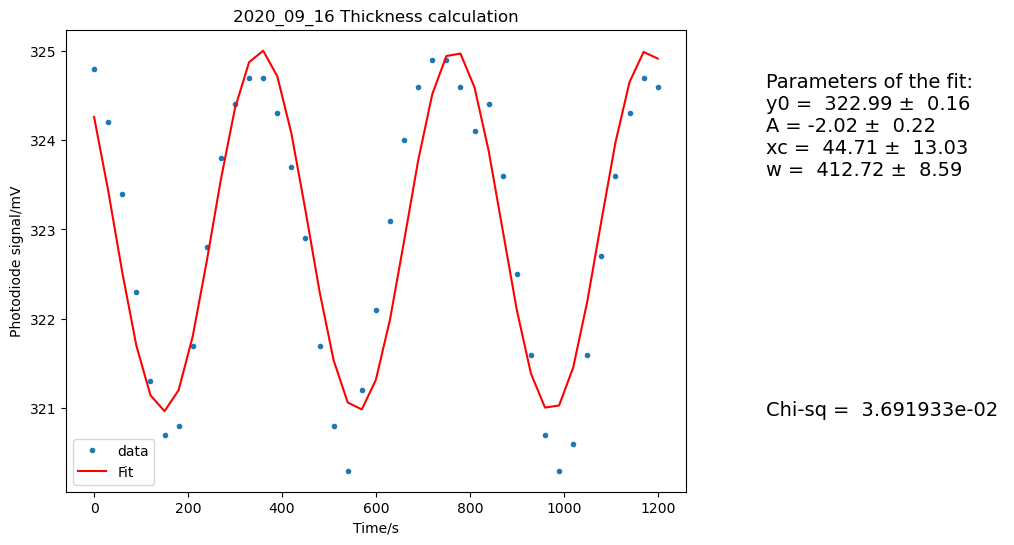

Chi-sq =  3.691933e-02 

Parameters of the fit:
y0 =  322.99 ±  0.16
A = -2.02 ±  0.22
xc =  44.71 ±  13.03
w =  412.72 ±  8.59



In [136]:
fig= plt.figure(figsize=(8,6))


t1 = str(f"Chi-sq = {chi_squared: 2e} \n")

t2 = str(f"Parameters of the fit:\n\
y0 = {popt[0]: .2f} \u00B1 {perr[0]: .2f}\n\
A = {popt[1]: .2f} \u00B1 {perr[1]: .2f}\n\
xc = {popt[2]: .2f} \u00B1 {perr[2]: .2f}\n\
w = {popt[3]: .2f} \u00B1 {perr[3]: .2f}\n")

#plots:
plt.plot(x, y, '.', label='data' )
plt.plot(x, sinfit(x,*popt),'r-', label='Fit')
plt.title('{0} Thickness calculation'.format(date))
plt.xlabel('Time/s')
plt.ylabel(r'Photodiode signal/mV')
plt.legend()
plt.text(1, 0.2, t1, fontsize=14, transform=plt.gcf().transFigure)
plt.text(1, 0.6, t2, fontsize=14, transform=plt.gcf().transFigure)

plt.savefig('..\..\Data\DATA_PROCESSING\{}/Plots/Thickness-calculation_{}_1.png'.format(date, date), bbox_inches="tight")


plt.show()

#print calculated chi suqared
t1 = print(f"Chi-sq = {chi_squared: 2e} \n")

#print parameters of the fit
t2 = print(f"Parameters of the fit:\n\
y0 = {popt[0]: .2f} \u00B1 {perr[0]: .2f}\n\
A = {popt[1]: .2f} \u00B1 {perr[1]: .2f}\n\
xc = {popt[2]: .2f} \u00B1 {perr[2]: .2f}\n\
w = {popt[3]: .2f} \u00B1 {perr[3]: .2f}\n")







### Guess 2

Here we split the Dataframe in order to get only the subrange that we are interested in

#### Data frame slicing

- we want to call again the df and slice it within the suitable range we have extracted from plot1

In [94]:
#data_thick_clean

In [137]:
range_low = 0
range_high = 540

cut = (data_thick_clean['time/s'] > range_low) & (data_thick_clean['time/s'] < range_high)

data_thick_cut = data_thick_clean[cut]

In [138]:
data_thick_cut

,time/s,voltage/mV
1,30,324.2
2,60,323.4
3,90,322.3
4,120,321.3
5,150,320.7
6,180,320.8
7,210,321.7
8,240,322.8
9,270,323.8
10,300,324.4


In [139]:
def create_lists_from_df_columns2(df1, df2, col1, col2):
    x = df1[col1].tolist()
    y = df2[col2].tolist()
    return x, y


df1 = pd.DataFrame({'col1': data_thick_cut["time/s"]})
df2 = pd.DataFrame({'col2': data_thick_cut["voltage/mV"]})
x, y = create_lists_from_df_columns2(df1, df2, 'col1', 'col2')


In [140]:
x

[30,
 60,
 90,
 120,
 150,
 180,
 210,
 240,
 270,
 300,
 330,
 360,
 390,
 420,
 450,
 480,
 510]

In [141]:
#normal values

guess =[323, 3, 0, 450]
popt =[323, 3, 0, 450]

#17-09 values

#guess =[323, 4, 25, 50]
#popt =[324, 2.4, 25, 25]

#21_09

#guess =[325, 4, 2000, 4000]
#popt =[324, 2.4, 2000, 4000]



#fits the funtion and returns the parameters of the fit poppt[as many guesses as you have]
popt, pcov = curve_fit(sinfit, x, y, p0=guess, maxfev=10000, absolute_sigma=True)

#chi squared calculation
chi_squared = np.sum(((y-sinfit(x,*popt))**2)/(sinfit(x,*popt)) )
perr = np.sqrt(np.diag(pcov))

## Plot 2

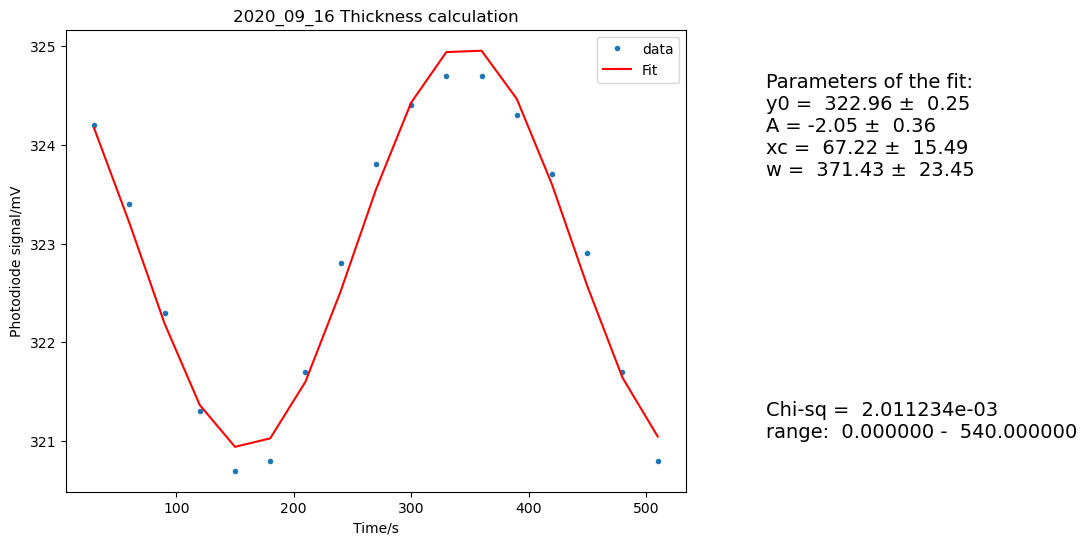

Chi-sq =  2.011234e-03 

Parameters of the fit:
y0 =  322.96 ±  0.25
A = -2.05 ±  0.36
xc =  67.22 ±  15.49
w =  371.43 ±  23.45



In [142]:
fig= plt.figure(figsize=(8,6))


t1 = str(f"Chi-sq = {chi_squared: 2e}  \n\
range: {range_low: 2f} - {range_high: 2f}")




t2 = str(f"Parameters of the fit:\n\
y0 = {popt[0]: .2f} \u00B1 {perr[0]: .2f}\n\
A = {popt[1]: .2f} \u00B1 {perr[1]: .2f}\n\
xc = {popt[2]: .2f} \u00B1 {perr[2]: .2f}\n\
w = {popt[3]: .2f} \u00B1 {perr[3]: .2f}\n")

#plots:
plt.plot(x, y, '.', label='data' )
plt.plot(x, sinfit(x,*popt),'r-', label='Fit')
plt.title('{0} Thickness calculation'.format(date))
plt.xlabel('Time/s')
plt.ylabel(r'Photodiode signal/mV')
plt.legend()
plt.text(1, 0.2, t1, fontsize=14, transform=plt.gcf().transFigure)
plt.text(1, 0.6, t2, fontsize=14, transform=plt.gcf().transFigure)

plt.savefig('..\..\Data\DATA_PROCESSING\{}/Plots/Thickness-calculation_{}_2.png'.format(date, date), bbox_inches="tight")


plt.show()

#print calculated chi suqared
t1 = print(f"Chi-sq = {chi_squared: 2e} \n")

#print parameters of the fit
t2 = print(f"Parameters of the fit:\n\
y0 = {popt[0]: .2f} \u00B1 {perr[0]: .2f}\n\
A = {popt[1]: .2f} \u00B1 {perr[1]: .2f}\n\
xc = {popt[2]: .2f} \u00B1 {perr[2]: .2f}\n\
w = {popt[3]: .2f} \u00B1 {perr[3]: .2f}\n")



# 3 Thickness Calculation

To calculate the film thickness we use the thin film interference equation:

$$d = \frac{\lambda_0}{2n_1 cos\theta_1}$$

where $\lambda_0$ is the wavelength of the laser in vacuum (632.8 nm), $n_1$ is the refractive index of the film and $\theta_1$ is the angle of reflection within the film (at the substrate/ice interface).

The refractive index of the film $n$ is estimated fromthe ratio of the maxima and the minima of the sinusoidal fit:

$$n = \frac{y_0 + A}{y_0 - A}$$

To obtain  $\theta_1$ we use Snell's law

$$n_1 sin\theta_1 = n_0 sin\theta_0$$

where $n_0 = 1$ in vacuum and $\theta_0$ is 20$^\circ$



In [143]:
#refractive index is given by n = (y0+A)/(y0-A)
n1=(popt[0]+popt[1])/(popt[0]-popt[1])

print (f"Refractive index of ice film, n1 = {n1: .2f} at 632.8 nm")

#n1*sin(theta1)=n0*sin(theta0), so theta1=arcsin(sin(20deg)/n1)
#!Attention, python numpy works in radians
theta0=np.radians(20)

theta1=np.arcsin(np.sin(theta0)/n1)
theta1_deg=np.rad2deg(theta1)

print (f"\ntheta1 = {theta1_deg: .2f} degrees")

#thickness per fringe, d = lambda(632.8)/2*n1*cos(theta1)
d=632.8/(2*n1*np.cos(theta1))

print (f"\nd = {d:.2f} nm per fringe")


Refractive index of ice film, n1 =  0.99 at 632.8 nm

theta1 =  20.27 degrees

d = 341.59 nm per fringe


Finally, to calculate the thickness:
$d$ gives the thickness per fringe and the period $w$ gives the time per fringe, so the rate given by thickness/time is (thickness/fringe)/(time/fringe) = $d/w$. 

In [144]:
#rate = (thickness/fringe) / (time/fringe)
rate=d/popt[3]

print (f"Deposition rate = {rate: .2f} nm/s")


Deposition rate =  0.92 nm/s


$\color{red}{\text{How to convert in ML/s}}$

To obtain the final thickness, multiply the rate (nm/s) by the total deposition time (s)

In [145]:
#enter deposition time, t in seconds
t= float(1200)

#calculate thickness, l in nm
thickness=rate*t

print (f"Ice film thickness, l = {thickness: .2f} nm")

Ice film thickness, l =  1103.58 nm


# 4 Data Export

In [146]:
Ice_thick_date = []

In [147]:
Ice_thick_date.append(
        
        {
            'Sample' : str(spl),
            'Date' : str(date),
            'n1' :  n1,
            'teta1' : theta1_deg,
            'd' : d,
            'rate' : rate,
            'thickness' : thickness,
            'Na' : "",
            'Nc' : "", 

            })

In [148]:
Ice_thick_date_df = pd.DataFrame(Ice_thick_date)

In [149]:
Ice_thick_date_df

,Sample,Date,n1,teta1,d,rate,thickness,Na,Nc
0,ASW,2020_09_16,0.987391,20.266541,341.587806,0.919652,1103.582241,,


In [154]:
Ice_thick_df = pd.read_csv('..\..\Data\Ice_thickness.csv')

In [151]:
XP_Date = []

XP_Date = str(Ice_thick_df['Date'])
print(XP_Date)

0    2020_09_15
Name: Date, dtype: object


In [152]:
#if date in XP_Date:
    #    print("Not appended")
#else:
Ice_thick_date_df.to_csv('..\..\Data\Ice_thickness.csv', mode='a', header=False, index=False)

## Data Visualisation

In [155]:
Ice_thick_df

,Sample,Date,n1,teta1,d,rate,thickness,Na,Nc,Unnamed: 9,Unnamed: 10
0,ASW,2020_09_15,0.993048,20.146063,339.379074,0.755029,906.035050,NaN,NaN,NaN,NaN
1,ASW,2020_09_16,0.987391,20.266541,341.587806,0.919652,1103.582241,NaN,NaN,NaN,NaN


# Export Result in web-page

In [388]:
f = open("D:\DATA-Processing\PAC\{}/Samples/{}/{}_DP.html".format(XP,date,date),'a')



message = """<html>
<head></head>
<body>



<h1>Sample thickness </h1>

<figure>
<a href="Plots\DR\Thickness-calc_"""+str(date) + """_2.png" target="_blank"><image src="Plots\DR\Thickness-calc_"""+str(date) + """_2.png" width=""  Id=""  alt=""/></a>      
<figcaption></figcaption>
</figure>

<p>Output</p>





</body>
</html>"""




f.write(message)
f.close()